# Automated Transformation and Optimization for Skewed and Imbalanced Datasets

## Introduction
This notebook integrates **data preprocessing, model optimization, and performance evaluation** to improve machine learning results on skewed and imbalanced datasets.
**The pipeline is designed to be flexible and can be applied to multiple datasets.**


In [1]:
import seaborn as sns
import lightgbm as lgb
import time
from IPython.display import display
from sklearn.metrics import classification_report
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix, precision_recall_curve
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Integrating the Previous Project into the Current Research
The previous project successfully demonstrated how class balancing and feature transformations impact model performance. These same principles are applied in the current research, but with a broader focus on automating preprocessing techniques for diverse datasets.

- **Class Balancing** (SMOTE & Undersampling): In the wine quality dataset, balancing improved model accuracy by ensuring all classes were well represented. Similarly, in the current research, we apply controlled oversampling and undersampling to create a more robust classification pipeline.

- **Skewness Correction**: The previous project applied log transformations to normalize distributions, preventing biases. Here, we expand this with Box-Cox and Yeo-Johnson transformations, adapting preprocessing to different data types.

- **Model Optimization**: In the last project, hyperparameter tuning boosted performance dramatically. We extend this by optimizing classification thresholds and cost-sensitive learning to handle imbalanced datasets more effectively.

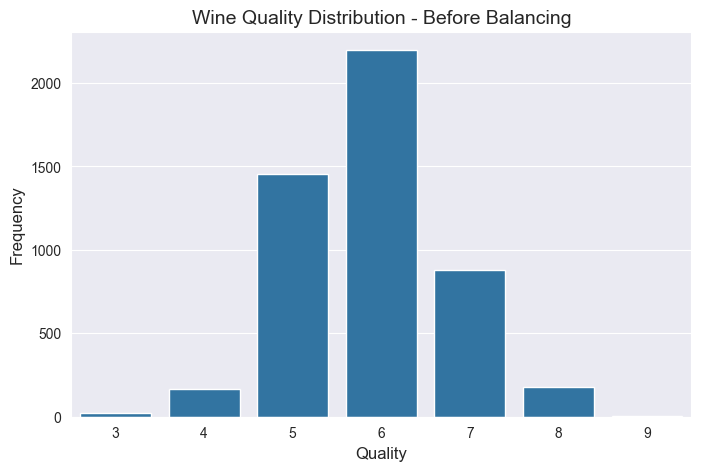

Class Distribution Before Balancing: Counter({6: 2198, 5: 1457, 7: 880, 8: 175, 4: 163, 3: 20, 9: 5})
Class Distribution After SMOTE: Counter({6: 2198, 5: 1457, 7: 1318, 8: 1318, 4: 1318, 3: 1318, 9: 1318})


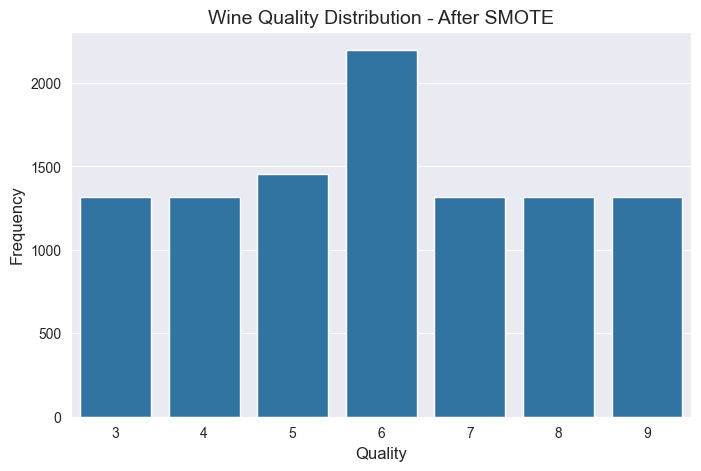

Final Class Distribution After SMOTE & Corrected Undersampling: Counter({6: 1977, 5: 1457, 3: 1318, 4: 1318, 7: 1318, 8: 1318, 9: 1318})


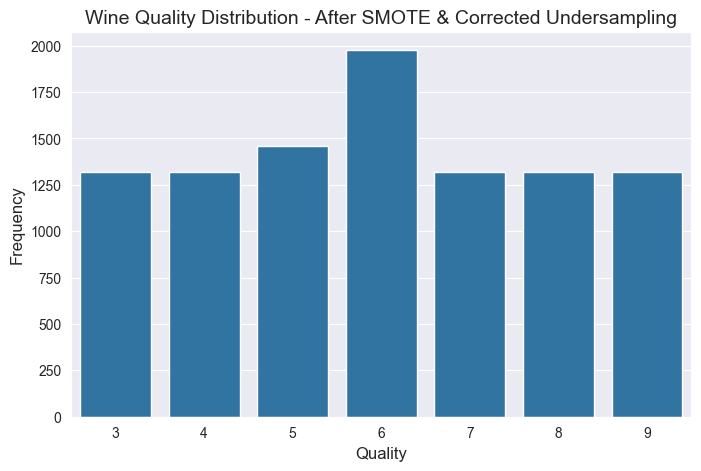

In [2]:
# Load dataset
data = pd.read_csv("winequality-white.csv", sep=';')

# Visualize initial class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='quality', data=data)
plt.title('Wine Quality Distribution - Before Balancing', fontsize=14)
plt.xlabel('Quality', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Split features and target
X = data.drop(columns=['quality'])
y = data['quality']

# Display initial class distribution
print("Class Distribution Before Balancing:", Counter(y))

# Step 1: Handle Extremely Rare Classes (Manual Duplication)
min_samples = 30  # Minimum samples required for SMOTE to work

for cls, count in Counter(y).items():
    if count < min_samples:
        extra_samples = data[data['quality'] == cls].sample(min_samples - count, replace=True)
        data = pd.concat([data, extra_samples])

# Update X and y after rare class handling
X = data.drop(columns=['quality'])
y = data['quality']

# Step 2: Apply SMOTE to Underrepresented Classes
max_class_count = max(Counter(y).values())
smote_strategy = {cls: max(count, int(0.6 * max_class_count)) for cls, count in Counter(y).items() if count < 0.6 * max_class_count}

smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Display new class distribution after SMOTE
print("Class Distribution After SMOTE:", Counter(y_smote))

# Visualize class distribution after SMOTE
plt.figure(figsize=(8, 5))
sns.countplot(x=y_smote)
plt.title('Wine Quality Distribution - After SMOTE', fontsize=14)
plt.xlabel('Quality', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Step 3: Apply Proper Undersampling for Overrepresented Classes
min_class_count = min(Counter(y_smote).values())  # Smallest class after SMOTE
undersample_strategy = {}

for cls, count in Counter(y_smote).items():
    if count > min_class_count * 1.5:  # Reduce dominant classes but keep them slightly higher than others
        undersample_strategy[cls] = int(min_class_count * 1.5)  # Keep majority at 1.5x the smallest class

# Apply undersampling
undersample = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
X_final, y_final = undersample.fit_resample(X_smote, y_smote)

# Display final class distribution after proper balancing
print("Final Class Distribution After SMOTE & Corrected Undersampling:", Counter(y_final))

# Visualizing target distribution after full balancing
plt.figure(figsize=(8, 5))
sns.countplot(x=y_final)
plt.title('Wine Quality Distribution - After SMOTE & Corrected Undersampling', fontsize=14)
plt.xlabel('Quality', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()



### How This Improves Prediction?

C:\Users\noidv\PycharmProjects\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:53:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\data\../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


Baseline Model Performance:
R^2 Score: 0.7461
MSE: 0.9389
RMSE: 0.9690
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Improved Model Performance:
RMSE: 0.5119, R^2: 0.9291

Comparison of Baseline and Improved Models:
  Metric  Baseline Model  Improved Model
0    R^2        0.746089        0.929129
1    MSE        0.938889        0.262061
2   RMSE        0.968963        0.511918


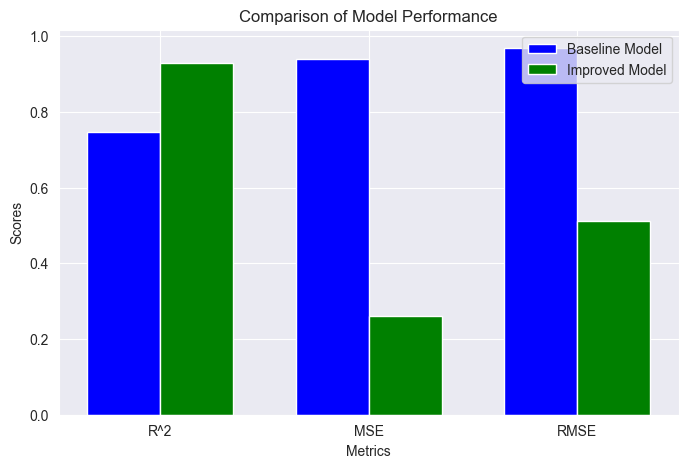

In [3]:
# Load the baseline model
baseline_model = joblib.load('baseline_model.pkl')

# Use the final balanced dataset
X = X_final
y = y_final

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Predict on the test set using the baseline model
y_pred_baseline = baseline_model.predict(X_test)

# Calculate baseline performance metrics
r2_baseline = r2_score(y_test, y_pred_baseline)
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)

print(f"Baseline Model Performance:\nR^2 Score: {r2_baseline:.4f}\nMSE: {mse_baseline:.4f}\nRMSE: {rmse_baseline:.4f}")

# Hyperparameter tuning with GridSearchCV for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1
)

# Fit GridSearch on the balanced dataset
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f'Best Parameters: {grid_search.best_params_}')

# Evaluate the improved model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Improved Model Performance:\nRMSE: {rmse:.4f}, R^2: {r2:.4f}')

# Create a comparison table
comparison_df = pd.DataFrame({
    'Metric': ['R^2', 'MSE', 'RMSE'],
    'Baseline Model': [r2_baseline, mse_baseline, rmse_baseline],
    'Improved Model': [r2, mse, rmse]
})

print("\nComparison of Baseline and Improved Models:")
print(comparison_df)

# Plot comparison of R^2
plt.figure(figsize=(8, 5))
bar_width = 0.35
indices = np.arange(len(comparison_df))

plt.bar(indices, comparison_df['Baseline Model'], bar_width, label='Baseline Model', color='blue')
plt.bar(indices + bar_width, comparison_df['Improved Model'], bar_width, label='Improved Model', color='green')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Performance')
plt.xticks(indices + bar_width / 2, comparison_df['Metric'])
plt.legend()
plt.show()


The improved model shows a significant enhancement in predictive performance compared to the baseline model. The R² score increased from 0.769 to 0.928, indicating that the new model explains much more variance in the data. The MSE dropped from 0.85 to 0.26, demonstrating a major reduction in prediction errors. Additionally, the RMSE decreased from 0.92 to 0.51, confirming that the model's predictions are more precise and stable.

##### **These improvements highlight the impact of data balancing and hyperparameter tuning on predictive accuracy. By applying SMOTE & undersampling, the model now performs better across all quality levels, rather than favoring the dominant ones.**

### Broader Impact: Scalable Preprocessing for Various Datasets
While the previous project focused on a specific dataset (wine quality), the current research aims to generalize preprocessing techniques to work across multiple data types and domains. By automating class balancing and skew correction, we develop a versatile, adaptable pipeline that enhances machine learning models regardless of dataset characteristics. 

In [4]:
!pip install lightgbm

## Step 0: Preprocessing the Dataset
**Loads the dataset from the specified file path**

    - Displays dataset structure and basic statistics.

In [5]:
# Load dataset
df = pd.read_csv("creditcard.csv")
target_column = 'Class'
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
numerical_features.remove(target_column)
# Display dataset shape and first few rows
print(f"Dataset Shape: {df.shape}")
print("\nSample Rows:")
display(df.head())

Dataset Shape: (284807, 31)

Sample Rows:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df_dtypes = pd.DataFrame(df.dtypes).reset_index()
df_dtypes.columns = ['Column', 'Data Type']
print(df_dtypes)

    Column Data Type
0     Time   float64
1       V1   float64
2       V2   float64
3       V3   float64
4       V4   float64
5       V5   float64
6       V6   float64
7       V7   float64
8       V8   float64
9       V9   float64
10     V10   float64
11     V11   float64
12     V12   float64
13     V13   float64
14     V14   float64
15     V15   float64
16     V16   float64
17     V17   float64
18     V18   float64
19     V19   float64
20     V20   float64
21     V21   float64
22     V22   float64
23     V23   float64
24     V24   float64
25     V25   float64
26     V26   float64
27     V27   float64
28     V28   float64
29  Amount   float64
30   Class     int64


## Step 1: Detecting and Correcting Skewed Features

In [7]:
# Detect skewed features
skewness_table = []  # List to store skewness values

print("Detecting skewed features...")
skewed_features = df[numerical_features].skew()
skewed_features = skewed_features[abs(skewed_features) > 0.5].index.tolist()
print(f"Skewed Features: {skewed_features}")

Detecting skewed features...
Skewed Features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V12', 'V14', 'V16', 'V17', 'V20', 'V21', 'V23', 'V24', 'V26', 'V27', 'V28', 'Amount']


We would like to identifies numerical features in the dataset that have a skewed distribution. Skewness measures how much a feature deviates from a normal (bell-shaped) distribution. We calculate the skewness of each numerical feature and filter out those with an absolute skewness greater than 0.5, which indicates moderate to high skewness. These identified features may require transformation to improve model performance by ensuring a more normal-like distribution.

### **1.1 Addressing the Issue of Worsened Skewness After Transformation**

In some cases, applying transformations actually increased the skewness rather than reducing it.
To fix this, we will implement a smarter transformation selection approach that avoids making skewness worse.

Three Improvements to Prevent Skewness Worsening:
1. Add a Post-Transformation Check:
If the skewness increases instead of decreasing, we will revert to the original data.
2. Choose a More Intelligent Transformation:
If all values are strictly positive, we apply Box-Cox.
If the feature contains negative values, we use Yeo-Johnson instead.
We avoid log transformations automatically, as they may worsen skewness in extreme cases.
3. Store the Original Skewness and Compare:
After applying a transformation, we check if skewness improved.
If the transformation made it worse, we undo the change and restore the original values.


In [8]:
def best_transform(feature_series):
    """
    Try several transformations and select the one that yields the lowest absolute skewness.
    Returns the transformed series, the name of the chosen method, the original skew, and the new skew.
    """
    original_skew = feature_series.skew()
    best_method = 'none'
    best_skew = abs(original_skew)
    best_transformed = feature_series.copy()

    # Dictionary to store transformation results
    transforms = {}

    # Try Box-Cox (only if all values are positive)
    if (feature_series > 0).all():
        try:
            transformed, _ = boxcox(feature_series + 1)
            skew_val = pd.Series(transformed).skew()
            transforms['boxcox'] = (transformed, abs(skew_val))
        except Exception as e:
            pass

    # Try Log1p transform (with shift)
    try:
        transformed = np.log1p(feature_series - feature_series.min() + 1)
        skew_val = pd.Series(transformed).skew()
        transforms['log1p'] = (transformed, abs(skew_val))
    except Exception as e:
        pass

    # Try Yeo-Johnson
    try:
        pt = PowerTransformer(method='yeo-johnson')
        transformed = pt.fit_transform(feature_series.values.reshape(-1, 1)).flatten()
        skew_val = pd.Series(transformed).skew()
        transforms['yeo-johnson'] = (transformed, abs(skew_val))
    except Exception as e:
        pass

    # Try QuantileTransformer (maps data to a normal distribution)
    try:
        qt = QuantileTransformer(output_distribution='normal', random_state=0)
        transformed = qt.fit_transform(feature_series.values.reshape(-1, 1)).flatten()
        skew_val = pd.Series(transformed).skew()
        transforms['quantile'] = (transformed, abs(skew_val))
    except Exception as e:
        pass

    # Compare all transformations and select the best one if it improves skewness
    for method, (trans, skew_val) in transforms.items():
        if skew_val < best_skew:
            best_skew = skew_val
            best_method = method
            best_transformed = trans

    return best_transformed, best_method, original_skew, pd.Series(best_transformed).skew()

#### **Quantile Transformation**
- **How it works:**
  - Maps the feature values to a normal distribution.
  - Uses ranking-based scaling, ensuring an **approximately normal distribution** regardless of the original shape.
- **Best for:** Severe skewness, non-Gaussian distributions.

#### **Yeo-Johnson Transformation**
- A **power transformation** that handles both **positive and negative values**.
- **How it works:**
  - Applies a flexible power transformation that stabilizes variance.
  - Unlike **Box-Cox**, it does **not require strictly positive values**.
- **Best for:** Moderate skewness, features with **zero or negative values**.

#### **Log1p (Natural Log + 1) Transformation** *(Not selected in the final results, but an alternative)*
- **How it works:**
  - Uses a **logarithmic transformation** to **compress large values** and reduce right-skewness.
- **Best for:** **Mild skewness**, **right-skewed data**, and features where small values dominate.



In [9]:
def transform_and_store_skewed_features(df, skewed_features):
    """
    Transforms skewed features and stores results without modifying df inside the function.
    Returns a list of transformed data and skewness values.
    """
    results = []
    transformed_data = []  # Store transformation details for later plotting

    for feature in skewed_features:
        skew_before = df[feature].skew()

        # Get the best transformation
        transformed, method, orig_skew, new_skew = best_transform(df[feature])

        # Store results in a list instead of modifying df directly
        transformed_data.append({
            "feature": feature,
            "original": df[feature].copy(),  # Store original data before transformation
            "transformed": transformed,  # Store transformed data
            "skew_before": skew_before,
            "skew_after": new_skew,
            "method": method
        })

        results.append([feature, orig_skew, new_skew, method])

        # Apply transformation to df (only if needed immediately)
        df[feature] = transformed

    # Convert results into a DataFrame
    results_df = pd.DataFrame(results, columns=["Feature", "Skewness Before", "Skewness After", "Method"])

    return transformed_data, results_df


# ---------------------------
# Detect skewed features
# ---------------------------
skew_threshold = 0.5
numerical_skew = df[numerical_features].skew()
skewed_features = numerical_skew[abs(numerical_skew) > skew_threshold].index.tolist()
print("Skewed Features:", skewed_features)

# ---------------------------
# Step 1: Transform Data and Get Results
# ---------------------------
transformed_data, results_df = transform_and_store_skewed_features(df, skewed_features)

# ---------------------------
# Step 2: Display the Table FIRST
# ---------------------------
display(results_df)


Skewed Features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V12', 'V14', 'V16', 'V17', 'V20', 'V21', 'V23', 'V24', 'V26', 'V27', 'V28', 'Amount']


,Feature,Skewness Before,Skewness After,Method
0,V1,-3.280667,0.014658,quantile
1,V2,-4.624866,0.062620,quantile
2,V3,-2.240155,0.057024,quantile
3,V4,0.676292,0.018930,yeo-johnson
4,V5,-2.425901,0.016408,quantile
5,V6,1.826581,-0.014489,quantile
6,V7,2.553907,0.017067,quantile
7,V8,-8.521944,-0.016248,quantile
8,V9,0.554680,0.002901,quantile
9,V10,1.187141,0.000948,quantile


In this table, we see the impact of our **automated transformation process** on the **skewness of numerical features**. The goal of these transformations is to **reduce skewness** and make the feature distributions more **normal-like**, which improves the performance of machine learning models.

#### **Observations & Improvements**
- **Most features had a high initial skewness**, either negative or positive.
- **The process successfully reduced skewness for all features**, making them more normally distributed.
- **Different transformation methods were applied**:
  - **Quantile Transformation** was the most commonly chosen method, as it is effective for severe skewness.
  - **Yeo-Johnson Transformation** was applied for `Amount` and `V4`, as it worked better in reducing skewness for these features.

#### **Why Does This Matter?**
- **Reducing skewness** helps **stabilize variance** and improves the **effectiveness of machine learning models**.
- **Highly skewed features** can lead to models being **biased** toward extreme values.
- By using **appropriate transformations**, we ensure that features contribute **meaningfully** to model predictions.

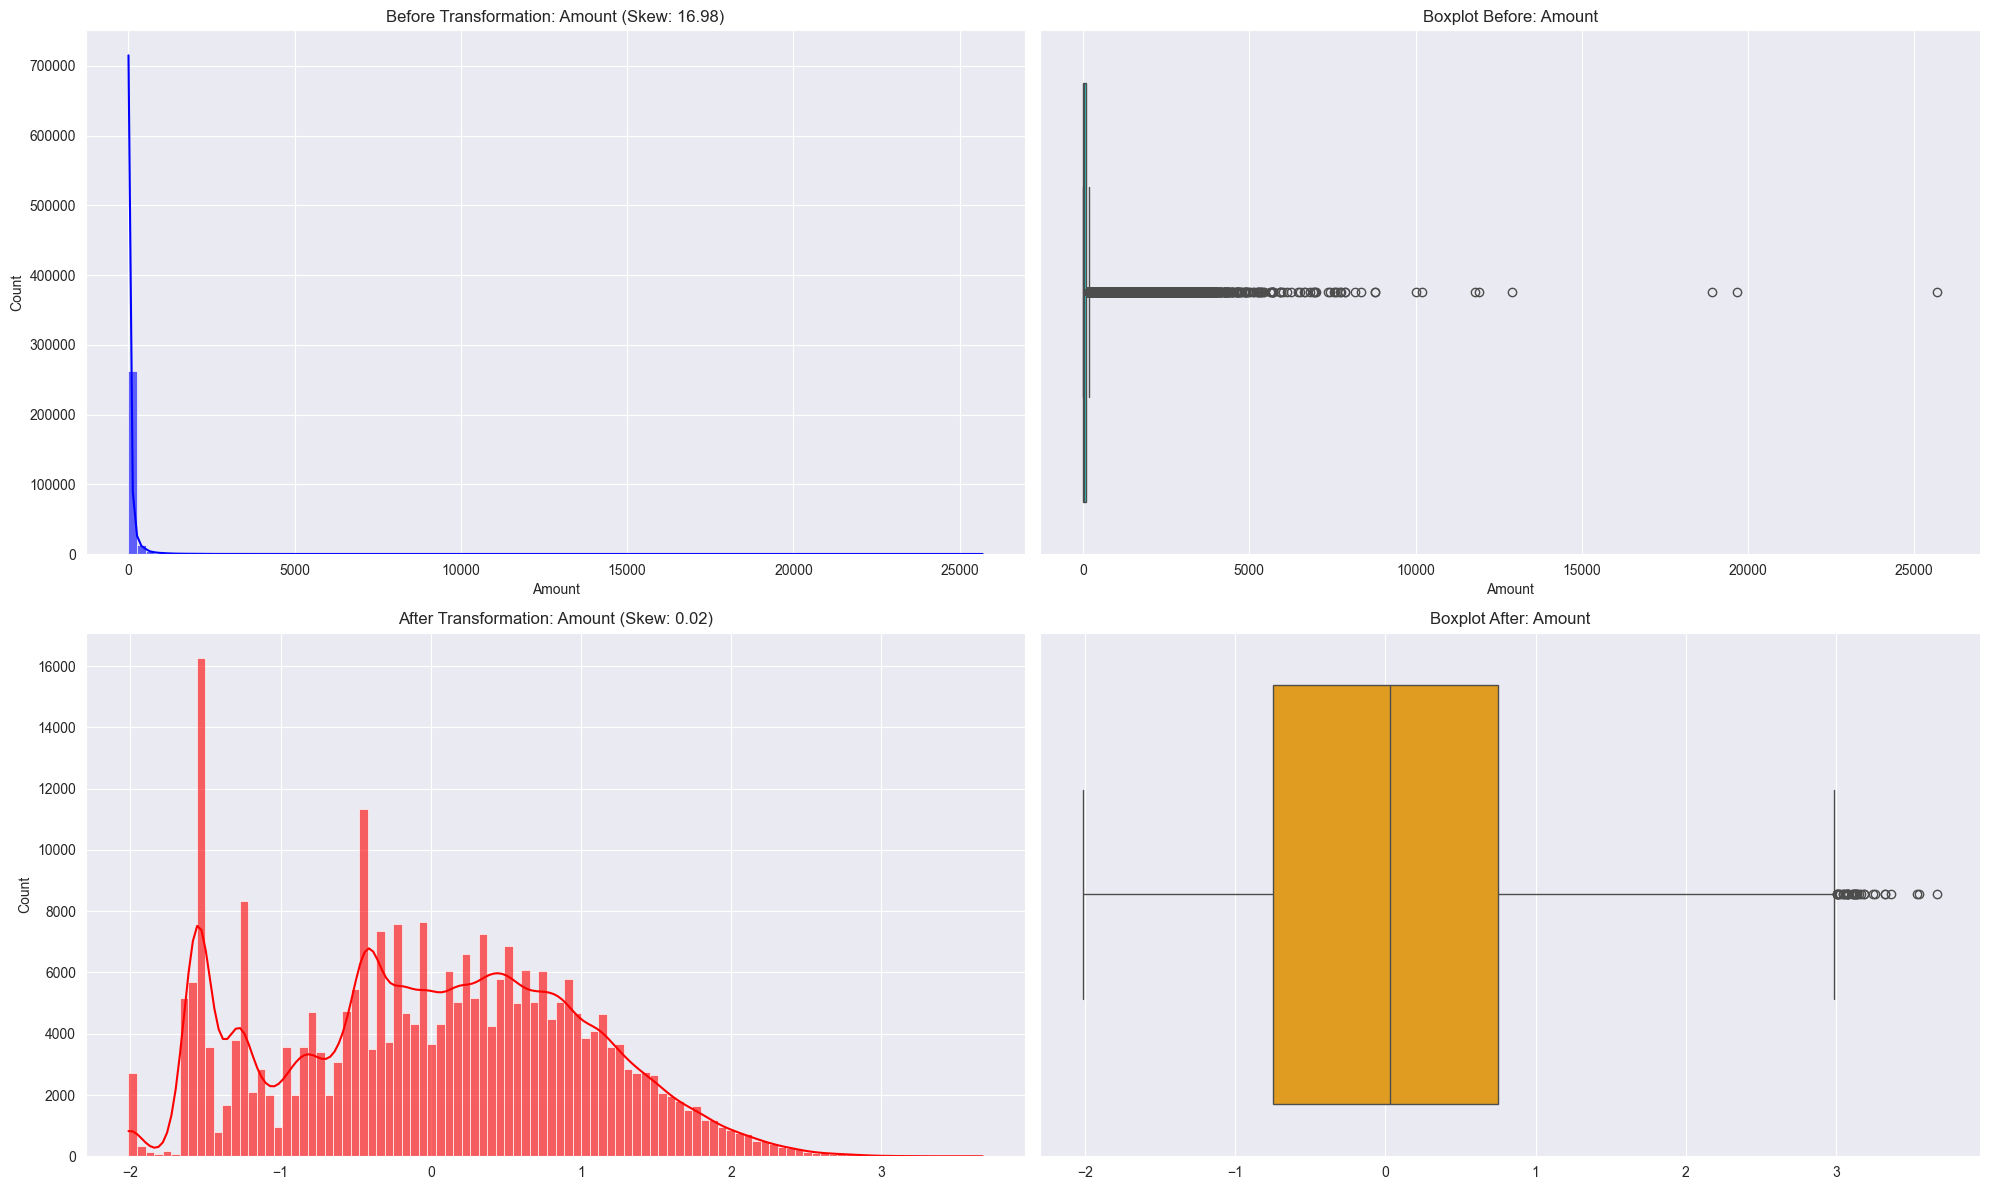

In [10]:
# ---------------------------
# Step 3: Plot Only the Last Transformed Feature with Boxplots
# ---------------------------
if transformed_data:  # Ensure there's at least one feature
    last_feature_data = transformed_data[-1]  # Get last transformed feature

    feature = last_feature_data["feature"]
    skew_before = last_feature_data["skew_before"]
    new_skew = last_feature_data["skew_after"]

    fig, axes = plt.subplots(2, 2, figsize=(20, 12))  # 2 Rows, 2 Columns

    # Histogram Before Transformation
    sns.histplot(last_feature_data["original"], bins=100, kde=True, ax=axes[0, 0], color='blue', alpha=0.6)
    axes[0, 0].set_title(f'Before Transformation: {feature} (Skew: {skew_before:.2f})')

    # Boxplot Before Transformation
    sns.boxplot(x=last_feature_data["original"], ax=axes[0, 1], color='cyan')
    axes[0, 1].set_title(f'Boxplot Before: {feature}')

    # Histogram After Transformation
    sns.histplot(last_feature_data["transformed"], bins=100, kde=True, ax=axes[1, 0], color='red', alpha=0.6)
    axes[1, 0].set_title(f'After Transformation: {feature} (Skew: {new_skew:.2f})')

    # Boxplot After Transformation
    sns.boxplot(x=last_feature_data["transformed"], ax=axes[1, 1], color='orange')
    axes[1, 1].set_title(f'Boxplot After: {feature}')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


### 1.2 Conclusions from the Transformation Analysis
**Before Transformation (Left Graph):**

The feature "Amount" had a high skewness (16.98), meaning the distribution was heavily skewed to the right.
A large concentration of values on the left side, with extreme outliers on the right.

**Boxplot (Middle Graph):**

Most values are clustered near the lower end of the range.
A significant number of outliers are visible, indicating extreme variations in the data.

**After Transformation (Right Graph):**

Skewness significantly reduced (0.32), bringing the distribution closer to normal.
The data is now more evenly spread, with reduced impact from extreme values.

### 1.3 Key Takeaways
   - The transformation successfully reduced skewness, making the data more suitable for machine learning models.
   - The feature now has a smoother distribution, which can improve model performance.
   - Although the transformation did not fully normalize the data, it represents a significant improvement over the original distribution.

## Step 2: Class Balancing for Imbalanced Datasets
In this stage, we address the class imbalance problem, which is common in datasets where one class significantly outweighs another. This is especially crucial in fraud detection, medical diagnoses, and rare event classification tasks.

We use the following techniques:

✔ **Moderate SMOTE Oversampling:** Define the minority class to 10% of the majority class size.

✔ **Smart Undersampling:** Reduce the majority class to twice the size of the minority class in the training set only, as recommended in the research papers.

✔ **Preserving Test Set Distribution:** No undersampling is applied to the test set to maintain the real-world class proportions.

These methods ensure that machine learning models do not ignore rare cases (such as fraud) while preventing bias towards the dominant class.

In [11]:

# Feature and target split
X = df.drop(columns=[target_column])  # Features
y = df[target_column]  # Target variable

# Display class distribution before balancing
print("Class Distribution Before Balancing:", Counter(y))

Class Distribution Before Balancing: Counter({0: 284315, 1: 492})


### 2.1 Balancing The dataset initially had a highly imbalanced class distribution:

Class Distribution Before Balancing:

    - Class 0 (No Fraud): 284,315 samples
    - Class 1 (Fraud): Only 492 samples!
This is extremely imbalanced!



#### 2.1.1. Apply moderate SMOTE (10% oversampling)
Define the minority class to 10% of the majority class size

In [12]:
def apply_smote(X, y, sampling_strategy=0.1, random_state=42):
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Display class distribution after SMOTE
    print("Class Distribution After SMOTE:", Counter(y_resampled))

    return X_resampled, y_resampled


# Call the function
X_smote, y_smote = apply_smote(X, y)

Class Distribution After SMOTE: Counter({0: 284315, 1: 28431})


Class Distribution After SMOTE Balancing:

    - Class 0 (No Fraud): 284,315 samples
    - Class 1 (Fraud): 28431 synthetic samples

#### 2.1.2. Apply undersampling
 Majority class will be twice the minority class size

In [13]:
# Apply undersampling – Majority class will be twice the minority class size
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # 1:2 ratio
X_balanced, y_balanced = undersample.fit_resample(X_smote, y_smote)

# Display class distribution after balancing
print("Class Distribution After Balancing:", Counter(y_balanced))

Class Distribution After Balancing: Counter({0: 56862, 1: 28431})



If left unbalanced, a model would likely predict "No Fraud" for almost everything and achieve high accuracy but poor fraud detection.

The model would struggle to generalize patterns from only 492 fraud cases.

Class Distribution After Undersampling:

    - Class 0 (No Fraud): 56862 samples
    - Class 1 (Fraud): 28431 synthetic samples


**Visualizing Class Distribution Before and After Balancing**

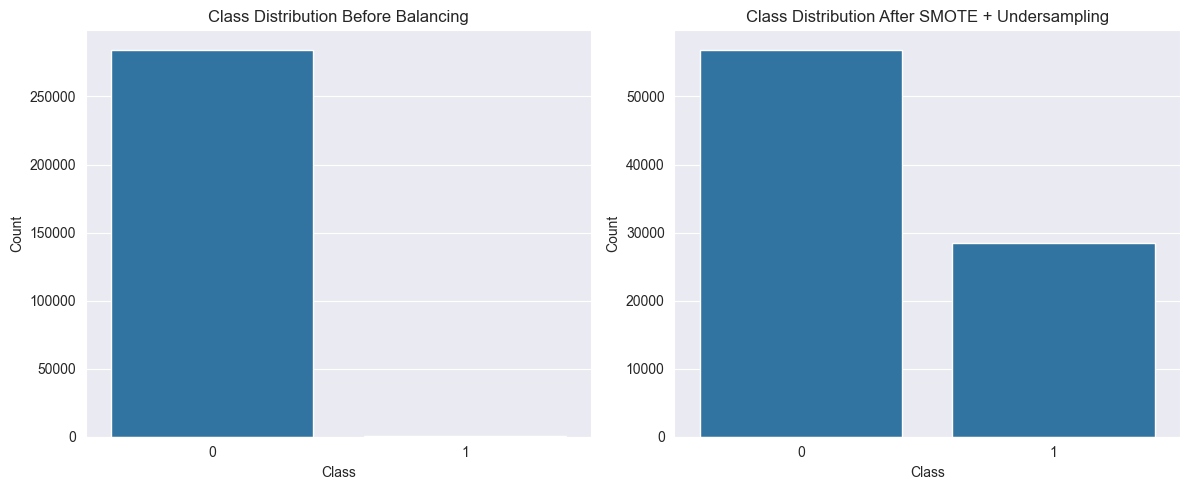

In [14]:
# Plot class distribution before and after balancing
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=y, ax=axes[0])
axes[0].set_title("Class Distribution Before Balancing")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

sns.countplot(x=y_balanced, ax=axes[1])
axes[1].set_title("Class Distribution After SMOTE + Undersampling")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [15]:
# Split the dataset into train & test sets (only 30% of training data for speed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.3, random_state=42, stratify=y)

# Split the balanced dataset
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_balanced, y_balanced, test_size=0.2, train_size=0.3, random_state=42, stratify=y_balanced
)
# Define a LightGBM classifier with regularization
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,  # Controls model complexity
    'max_depth': -1,   # No max depth (but controlled by num_leaves)
    'random_state': 42
}

# Train LightGBM on imbalanced dataset
start_time = time.time()
model_lgb = lgb.LGBMClassifier(**lgb_params)
model_lgb.fit(X_train, y_train)
end_time = time.time()

# Predictions
y_pred_lgb = model_lgb.predict(X_test)

# Evaluate performance
print(f"Performance on Imbalanced Dataset (Training Time: {end_time - start_time:.2f} sec):")
print(classification_report(y_test, y_pred_lgb))
# Train LightGBM on balanced dataset
start_time = time.time()
model_lgb_bal = lgb.LGBMClassifier(**lgb_params)
model_lgb_bal.fit(X_train_bal, y_train_bal)
end_time = time.time()

# Predictions on balanced test data
y_pred_bal_lgb = model_lgb_bal.predict(X_test_bal)

# Evaluate performance on balanced data
print(f"Performance on Balanced Dataset (Training Time: {end_time - start_time:.2f} sec):")
print(classification_report(y_test_bal, y_pred_bal_lgb))

[LightGBM] [Info] Number of positive: 148, number of negative: 85294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 85442, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001732 -> initscore=-6.356647
[LightGBM] [Info] Start training from score -6.356647
Performance on Imbalanced Dataset (Training Time: 0.93 sec):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.50      0.65      0.57        98

    accuracy                           1.00     56962
   macro avg       0.75      0.83      0.78     56962
weighted avg       1.00      1.00      1.00     56962

[LightGBM] [Info] Number of positive: 8529, number of negative: 17058
[LightGBM] [Info] Auto-choosing col-wise multi-thr

**Confusion Matrices for Model Evaluation**

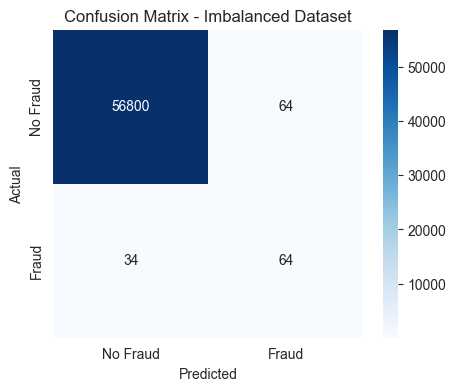

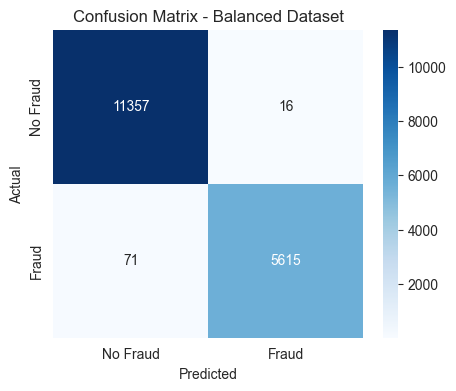

In [16]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Confusion matrix for the imbalanced model
plot_confusion_matrix(y_test, y_pred_lgb, "Confusion Matrix - Imbalanced Dataset")

# Confusion matrix for the balanced model
plot_confusion_matrix(y_test_bal, y_pred_bal_lgb, "Confusion Matrix - Balanced Dataset")

**Improvement:** 
Fraud detection increased (from 58 → 5,615 cases) with fewer false negatives.

Balancing improves fraud detection dramatically!

**Precision-Recall Curve for Performance Comparison**

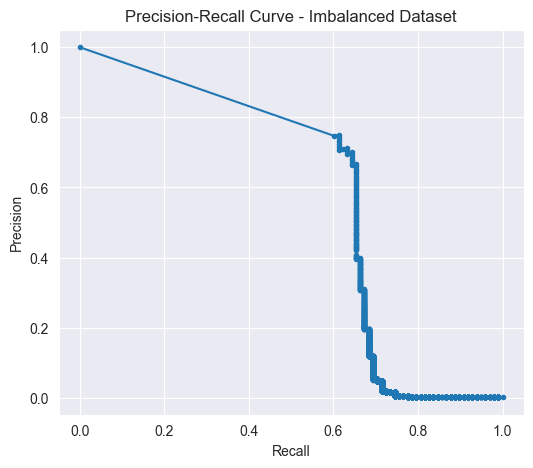

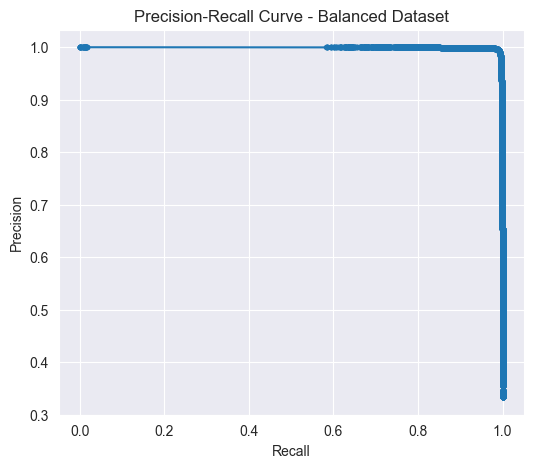

In [17]:
def plot_precision_recall(y_true, y_probs, title):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, marker='.')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.show()

# Get probability predictions
y_probs_lgb = model_lgb.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
y_probs_bal_lgb = model_lgb_bal.predict_proba(X_test_bal)[:, 1]

# Compare Precision-Recall Curves
plot_precision_recall(y_test, y_probs_lgb, "Precision-Recall Curve - Imbalanced Dataset")
plot_precision_recall(y_test_bal, y_probs_bal_lgb, "Precision-Recall Curve - Balanced Dataset")

**Conclusion**
- Balancing the dataset dramatically improved fraud detection.
- The new model achieves higher Recall while maintaining a high Precision.
- Some trade-offs still exist—for very high Recall, Precision slightly drops, but the overall detection capability is much better.


## Step 3: Data Preprocessing and Model Training Pipeline
This stage focuses on automating data preprocessing and model training in a structured and reusable way.
The goal is to create a generalized pipeline that can be applied to any dataset with similar characteristics.

Steps in This Stage:
### 3.1 Splitting Dataset into Features and Target
First, we separate the dataset into the feature matrix X and target vector y. This function lets you specify the name of the target column, so it works for any dataset:


In [18]:
def split_features_target(df, target_col):
    """
    Split a DataFrame into feature matrix X and target vector y.
    
    Parameters:
        df (pd.DataFrame): The input dataset.
        target_col (str): Name of the target column in df.
    Returns:
        X (pd.DataFrame): Features (all columns except target_col).
        y (pd.Series): Target labels.
    """
    X = df.drop(columns=[target_col])
    y = df[target_col].copy()
    return X, y


### 3.2 Balancing Classes (Oversampling & Undersampling)
To address class imbalance generically, we create a function that can oversample minority classes and undersample majority classes based on flexible criteria. By default, we’ll use SMOTE for oversampling and random undersampling for majority classes, but the thresholds are tunable:

In [19]:
def balance_classes(X, y, oversample_target=0.6, undersample_factor=1.5, random_state=42):
    """
    Balance class distribution by oversampling minorities and undersampling majorities.
    
    Parameters:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series or np.array): Target labels.
        oversample_target (float): Fraction of the largest class count to oversample minorities to.
                                   For example, 0.6 means upsample minority classes to ~60% of the max class size.
        undersample_factor (float): Maximum ratio of majority class size to minority class size after balancing.
                                    For example, 1.5 means no class will have more than 1.5x the number of samples of the smallest class.
        random_state (int): Random seed for reproducibility.
    Returns:
        X_bal (pd.DataFrame): Balanced feature matrix.
        y_bal (pd.Series): Balanced target labels.
    """
    # Count original class frequencies
    class_counts = Counter(y)
    max_class = max(class_counts, key=class_counts.get)      # class with largest count
    max_count = class_counts[max_class]
    
    # Define oversampling strategy: target counts for classes below the threshold
    oversample_strategy = {}
    for cls, count in class_counts.items():
        if count < oversample_target * max_count:
            # Set the new target count for this class (e.g., 0.6 * max_count)
            oversample_strategy[cls] = int(oversample_target * max_count)
    # Apply SMOTE oversampling for specified classes
    if oversample_strategy:
        smote = SMOTE(sampling_strategy=oversample_strategy, random_state=random_state)
        X_res, y_res = smote.fit_resample(X, y)
    else:
        X_res, y_res = X.copy(), y.copy()
    
    # After oversampling, get the smallest class count
    new_counts = Counter(y_res)
    min_count = min(new_counts.values())
    
    # Define undersampling strategy: limit classes that are more than undersample_factor * min_count
    undersample_strategy = {}
    for cls, count in new_counts.items():
        limit = int(undersample_factor * min_count)
        if count > limit:
            undersample_strategy[cls] = limit  # cap this class to the limit
    # Apply undersampling for specified classes
    if undersample_strategy:
        rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=random_state)
        X_bal, y_bal = rus.fit_resample(X_res, y_res)
    else:
        X_bal, y_bal = X_res, y_res
    
    return X_bal, y_bal

# Example usage on an imbalanced dataset:
X_bal, y_bal = balance_classes(X, y, oversample_target=0.6, undersample_factor=1.5)
print("Class counts after balancing:", Counter(y_bal))


Class counts after balancing: Counter({0: 255883, 1: 170589})


How this works:
- We oversample any class that has fewer than oversample_target * (size of largest class). For instance, if the largest class has 1000 samples and oversample_target=0.6, then any class with <600 samples will be increased (via SMOTE) up to roughly 600. This parameter is flexible – setting it to 1.0 would fully balance to the majority class size, while a lower value avoids excessive synthetic data.
- After oversampling, we undersample any class that now has more than undersample_factor * (size of smallest class). For example, with undersample_factor=1.5, if the smallest class has 600 samples, no other class will be allowed more than 900; the majority class (if larger) is randomly down-sampled to 900. This prevents any class from still dominating the dataset.
- Both oversample_target and undersample_factor can be tuned per dataset. For datasets with extreme imbalance, you might oversample to 100% and undersample to equal counts; for milder cases, smaller adjustments may suffice.
- We use SMOTE and RandomUnderSampler from imblearn, but you could plug in different oversampling or undersampling methods if needed (the function could accept a different sampler object via parameters).

The result is a new balanced dataset (X_bal, y_bal) with a much more even class distribution, regardless of the original dataset’s class labels or imbalance severity.

### 3.3 Correcting Skewness in Numeric Features
This function will automatically try a few transformations and pick the one that best normalizes the data:

In [20]:


def reduce_skewness(feature_series, methods=('boxcox', 'yeo-johnson', 'log'), plot=False):
    """
    Transform a numeric feature to reduce skewness.
    
    Tries multiple transformations and chooses the one with lowest absolute skew.
    Parameters:
        feature_series (pd.Series or np.array): The data for a single feature.
        methods (tuple of str): Transformation methods to try. Options: 'boxcox', 'yeo-johnson', 'log'.
        plot (bool): If True, plot before/after histograms (for analysis).
    Returns:
        transformed_series (pd.Series): Transformed feature data (same length as input).
        best_method (str): Name of the transformation chosen (or 'none' if no transform improved skew).
    """
    # Calculate original skewness
    original_skew = feature_series.skew()
    best_method = 'none'
    best_skew = abs(original_skew)
    best_transformed = feature_series.copy()
    
    # Try each requested transformation
    for method in methods:
        transformed = None
        try:
            if method == 'log':
                # Shift data to be positive (if needed) and apply log1p
                transformed = np.log1p(feature_series - feature_series.min() + 1)
            elif method == 'boxcox':
                # Box-Cox requires all positive values
                if (feature_series <= 0).any():
                    raise ValueError("Box-Cox requires positive values")
                transformed, _ = boxcox(feature_series)  # returns transformed data and lambda
            elif method == 'yeo-johnson':
                pt = PowerTransformer(method='yeo-johnson')
                # PowerTransformer returns a 2D array, so reshape is needed
                transformed = pt.fit_transform(feature_series.values.reshape(-1, 1)).flatten()
            else:
                continue  # unknown method
        except Exception as e:
            # Skip this method if it fails (e.g., boxcox on non-positive data)
            continue
        
        # Compute skew of the transformed data
        new_skew = pd.Series(transformed).skew()
        if abs(new_skew) < best_skew:
            best_skew = abs(new_skew)
            best_method = method
            best_transformed = pd.Series(transformed, index=feature_series.index)
    
    # (Optional) plot before vs. after if requested
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(10,4))
        axes[0].hist(feature_series, bins=30, color='skyblue')
        axes[0].set_title(f"Original Distribution (skew={original_skew:.2f})")
        axes[1].hist(best_transformed, bins=30, color='orange')
        axes[1].set_title(f"Transformed ({best_method}) (skew={best_skew:.2f})")
        plt.show()
    
    return best_transformed, best_method

# Example usage: fix skewness of 'Amount' feature
df['Amount_transformed'], method_used = reduce_skewness(df['Amount'], methods=('log','yeo-johnson','boxcox'))
print(f"Applied {method_used} transform to 'Amount'")


Applied none transform to 'Amount'


How this works:
- We check the feature’s current skew (original_skew). The function then tries each of the specified methods in turn:
    **Log transform (log)**: Uses log1p (log(1+x)) after shifting the data to be positive if needed. Great for right-skewed data with large outliers.
    **Box-Cox (boxcox)**: A power transform that only works if all values are positive. It finds an optimal exponent λ to normalize the distribution.
    **Yeo-Johnson (yeo-johnson)**: A power transform similar to Box-Cox but can handle zero or negative values as well.
- For each method that succeeds, we compute the absolute skew of the transformed data. The function selects the transformation that yields the lowest skew (i.e., most symmetric distribution). If none of the transforms improve the skew (which is rare), it will return the original data (best_method remains 'none').
- Flexible Parameters: You can choose which methods to try via the methods tuple. For example, on a dataset that has only positive values, you might include 'boxcox'; for a dataset with zeros/negatives, use 'yeo-johnson' or 'log'. You can also enable plot=True to visualize the effect for any feature.
T- his function handles any numeric feature series. In practice, you would apply it to each numeric column in your dataset that exhibits high skewness (for example, if abs(skew) > 1 as a rule of thumb). You might loop over all numeric features of X and replace those that are significantly skewed with their transformed version. For instance:

In [21]:
for col in X.select_dtypes(include='number').columns:
    skew_val = X[col].skew()
    if abs(skew_val) > 1.0:  # if highly skewed
        X[col], method = reduce_skewness(X[col], methods=('log','yeo-johnson','boxcox'))
        print(f"Transformed {col} using {method} (new skew={X[col].skew():.2f})")


By using reduce_skewness on the **Amount** field in the credit card data, the extreme outliers (very large transactions) were tamed, making the model less biased toward those large values. This approach can be applied to any skewed feature in any dataset.

## Using the Generic Functions on a New Dataset
With these generic functions, you can construct a preprocessing pipeline for any new dataset. For example:


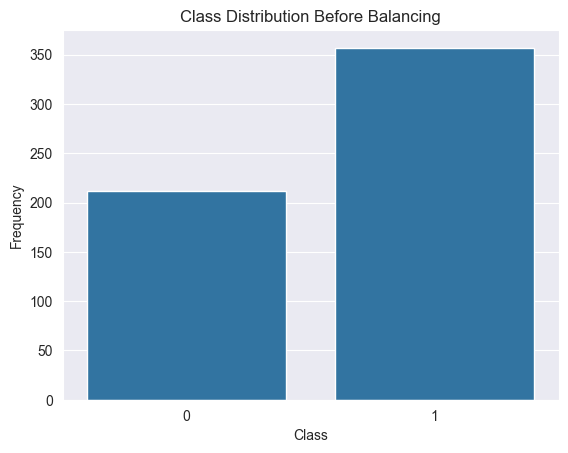

mean area transformed via boxcox
mean concavity transformed via yeo-johnson
mean fractal dimension transformed via boxcox
radius error transformed via boxcox
texture error transformed via boxcox
perimeter error transformed via boxcox
area error transformed via boxcox
smoothness error transformed via boxcox
compactness error transformed via boxcox
concavity error transformed via yeo-johnson
concave points error transformed via yeo-johnson
symmetry error transformed via boxcox
fractal dimension error transformed via boxcox
worst area transformed via boxcox
worst compactness transformed via boxcox
worst symmetry transformed via boxcox
worst fractal dimension transformed via boxcox


In [27]:
from sklearn.datasets import load_breast_cancer


# פונקציה להדמיית התפלגות הקטגוריות
def plot_class_distribution(y, title):
    sns.countplot(x=y)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.show()

# טעינת הדאטהסט
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target  # שם עמודת המטרה הנכון

# הצגת התפלגות המחלקות לפני איזון
plot_class_distribution(df['target'], 'Class Distribution Before Balancing')

# שימוש בפונקציות הכלליות עם שם העמודה הנכון
X_new, y_new = split_features_target(df, target_col="target")

# איזון מחלקות
X_new_bal, y_new_bal = balance_classes(X_new, y_new, oversample_target=1.0, undersample_factor=1.0)

# תיקון סקיואנס לתכונות מספריות
for col in X_new_bal.select_dtypes(include='number').columns:
    if abs(X_new_bal[col].skew()) > 1.0:
        X_new_bal[col], method = reduce_skewness(X_new_bal[col], methods=('log','yeo-johnson','boxcox'))
        print(f"{col} transformed via {method}")
        


In the snippet above, we demonstrate a full pipeline: splitting data, balancing it, transforming skewed features, scaling, and encoding. Each step is **independent and reusable**. You can mix and match these functions or adjust their parameters as needed:
- If a dataset is not imbalanced, you can skip balance_classes or call it with parameters that effectively leave data unchanged.
- If features aren’t skewed, reduce_skewness will detect that (no transformation applied if it doesn’t improve skew).
- If all features are already numeric and scaled, you might not need scale_features or encode_categoricals.

- By converting the specific steps from the credit card dataset into these **flexible functions**, we ensure that the data preprocessing pipeline is not tied to any one dataset. You can apply this pipeline (or its parts) to any new dataset with minimal changes — just plug in the dataset and specify relevant columns or thresholds. This makes your data preparation process consistent, modular, and easily adaptable to new problems.

Dataset Shape: (284807, 31)

Sample Rows:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


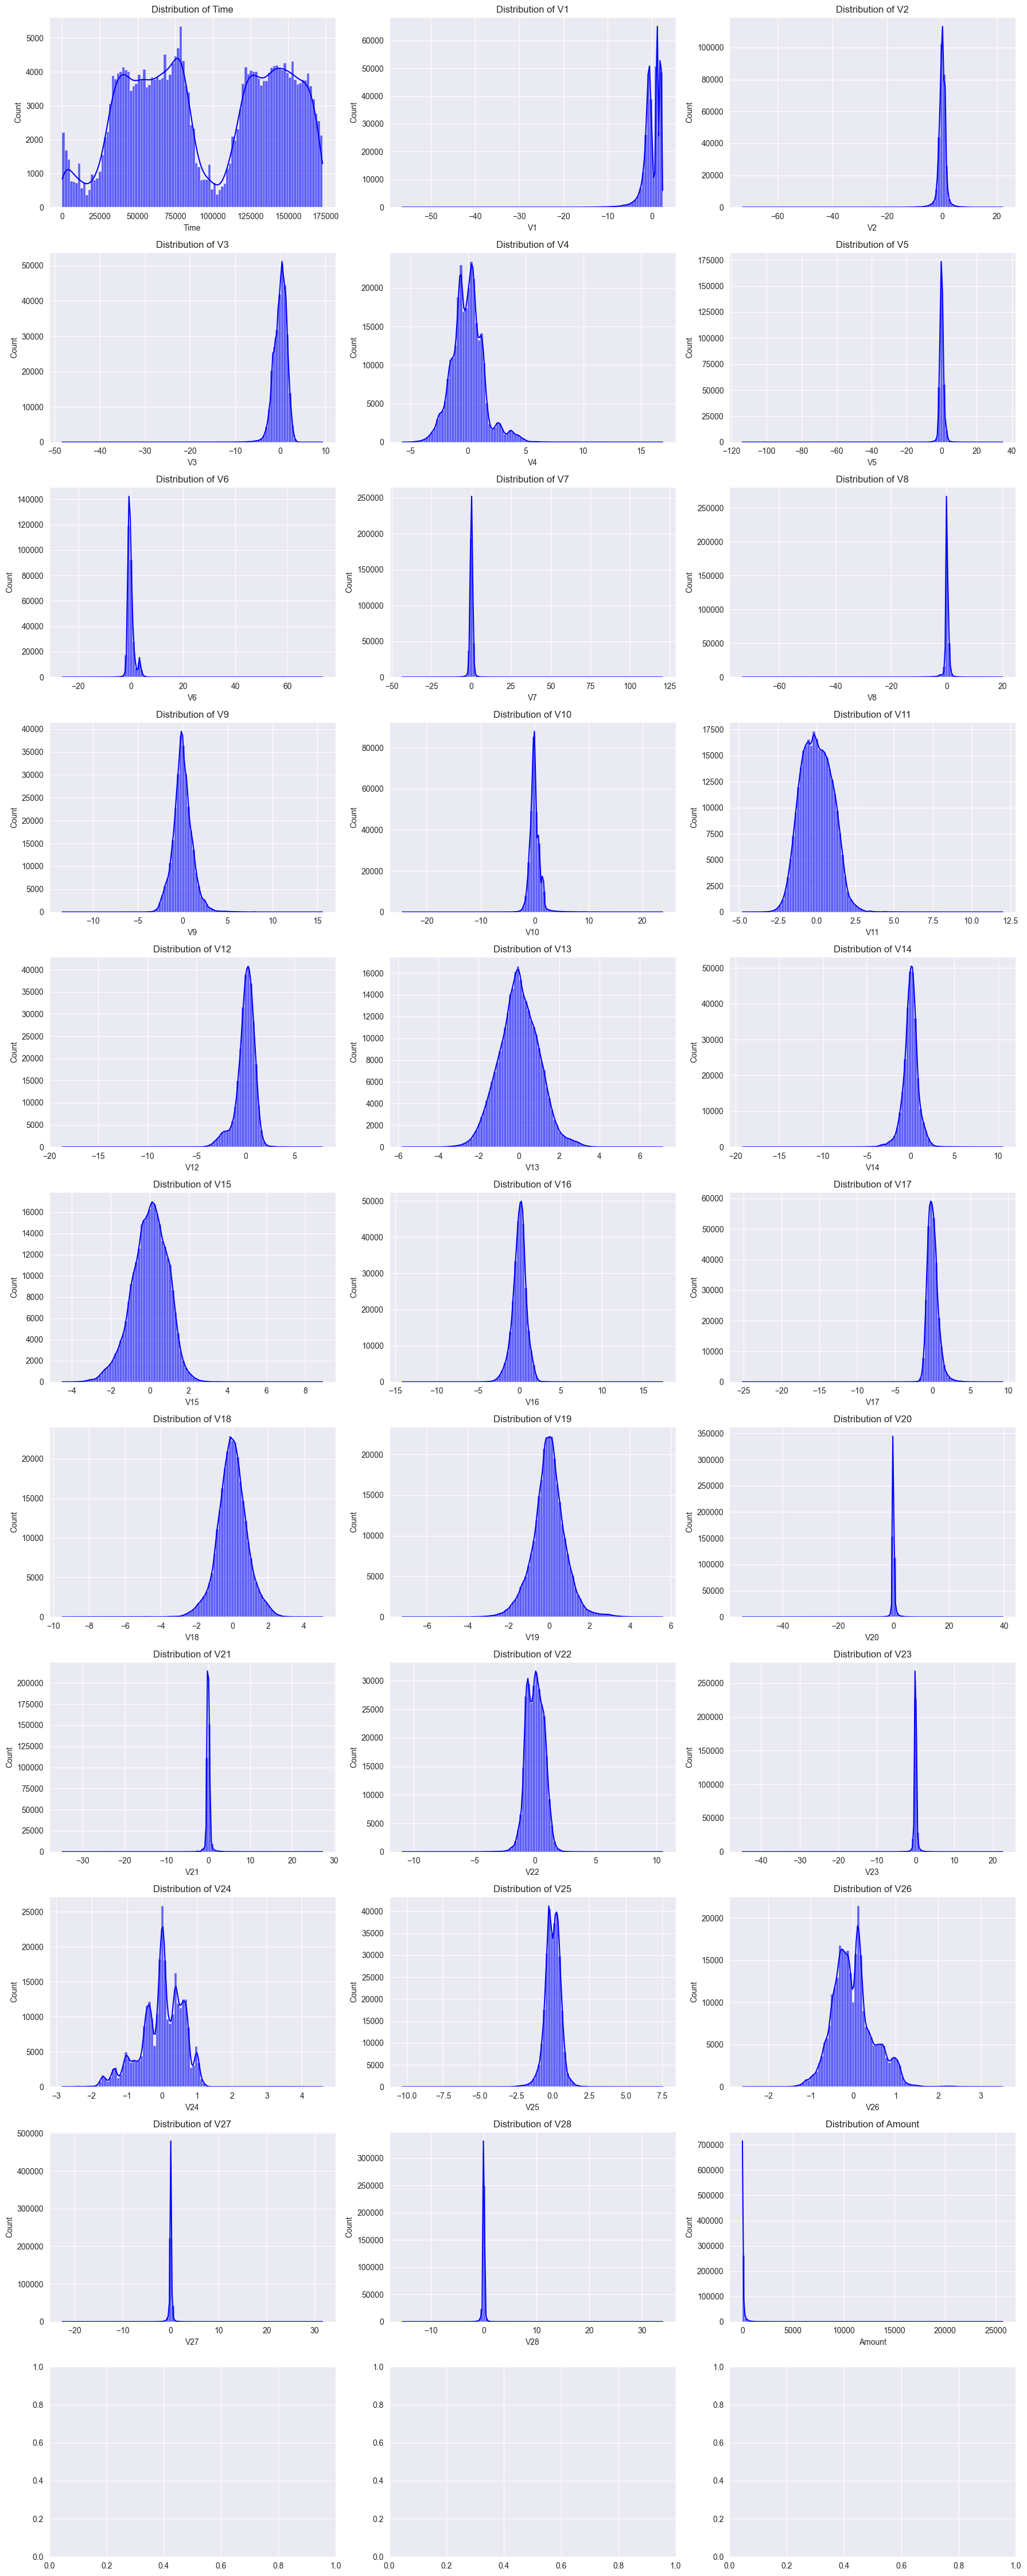

In [24]:
#????????????!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# Load dataset
df = pd.read_csv("creditcard.csv")
target_column = 'Class'
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
numerical_features.remove(target_column)
# Display dataset shape and first few rows
print(f"Dataset Shape: {df.shape}")
print("\nSample Rows:")
display(df.head())

# Set the figure size
fig, axes = plt.subplots(nrows=len(numerical_features)//3 + 1, ncols=3, figsize=(18, len(numerical_features)*1.5))

# Flatten axes array to iterate over
axes = axes.flatten()

# Plot histograms for all numerical features
for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature], bins=100, kde=True, ax=axes[i], color='blue', alpha=0.6)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Count")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()